### This code creates a heatmap that shows the average probabilty of beaching in a given location

Let's start by loading in the data and accomplishing 1

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [27]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.feature as cfeature

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [3]:
# import data
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

In [4]:
beach_count = beach_undrogued['id'].nunique()
unbeach_count = unbeach_undrogued['id'].nunique()

In [5]:
print(unbeach_count + beach_count)

16055


Now, let's visualize the probability of beaching

In [6]:
# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

In [7]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

In [8]:
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

In [9]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


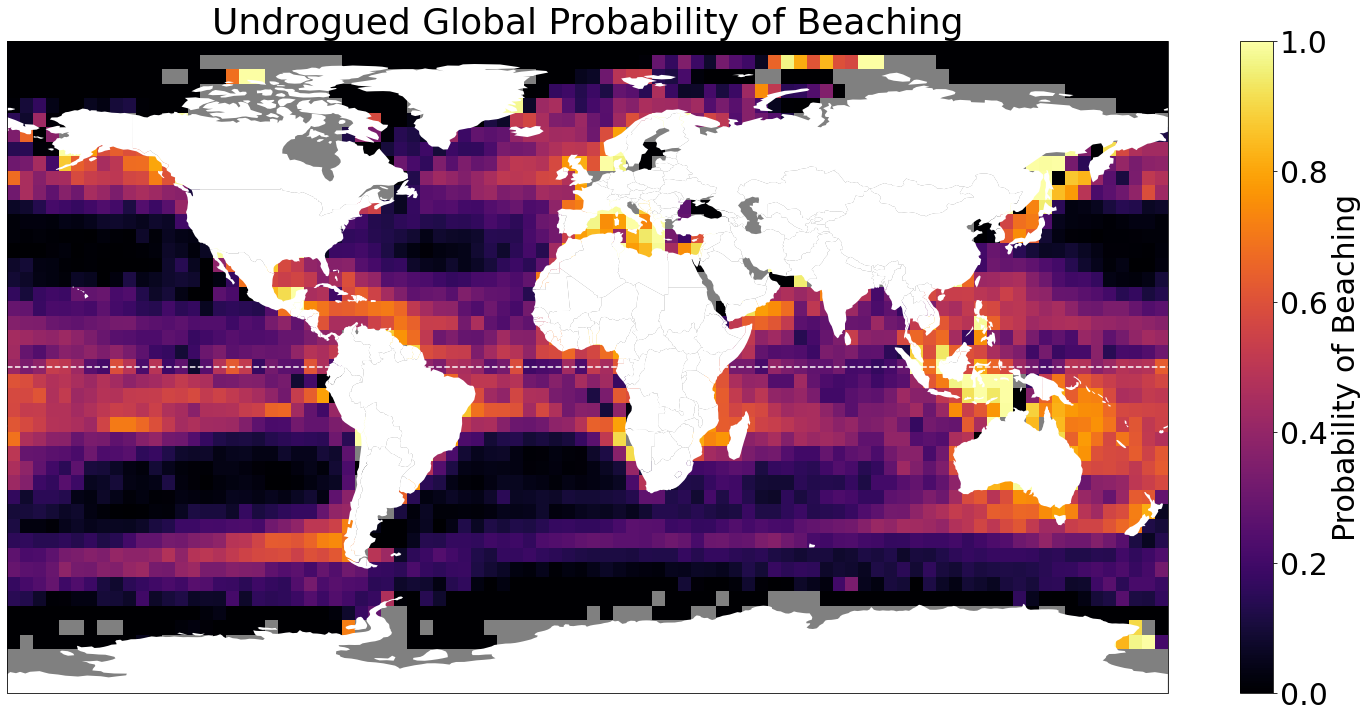

In [10]:
# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('Undrogued Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

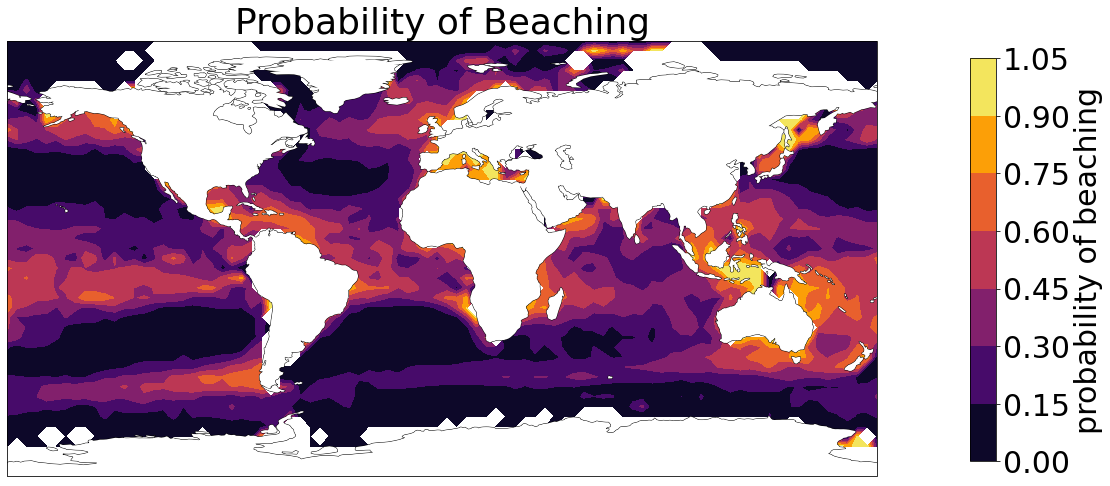

In [11]:
# define lat and lon:
lats = np.linspace(-90,90,45)
lons = np.linspace(-180, 180, 90)

# visualize
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, probability_undrogued.T, cmap='inferno', 
                   transform=ccrs.PlateCarree(), levels = 8)
ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='probability of beaching')

# Show the plot
plt.show()

# Now let's do this for time to beach

In [12]:
beach_undrogued

,id,time,lat,lon,ve,vn,time_to_beach
0,101509,1331078400,13.71750,124.71663,-0.1732,-0.0036,0.0
1,101510,1328140800,22.43137,120.45541,-0.0319,0.1226,363600.0
2,101510,1328144400,22.43232,120.45519,0.0035,-0.0570,360000.0
3,101510,1328148000,22.43020,120.45683,0.0063,-0.0559,356400.0
4,101510,1328151600,22.42962,120.45589,-0.0026,-0.0207,352800.0
...,...,...,...,...,...,...,...
23068316,99237,1276009200,35.62552,-121.83168,0.4754,-0.4431,14400.0
23068317,99237,1276012800,35.61114,-121.81313,0.4754,-0.4434,10800.0
23068318,99237,1276016400,35.59663,-121.79575,0.4548,-0.4522,7200.0
23068319,99237,1276020000,35.58199,-121.77910,0.4310,-0.4501,3600.0
